<a href="https://colab.research.google.com/github/MahmoudFarouq/faceVerification/blob/master/CNN_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from keras.optimizers import Adam
from keras.models import Model
from keras.initializers import glorot_uniform
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


In [0]:
from numpy.random import seed
seed(1)

from tensorflow.random import set_random_seed
set_random_seed(1)
drop = 0.3

In [0]:
def resNetBlock_Identity(X, f, filters, stage, block):
  
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'
  
  F1, F2, F3 = filters
  short_cut = X
  
  X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
  X = Activation('relu')(X)
  X = Dropout(drop)(X)
  
  X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same' , name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
  X = Activation('relu')(X)
  X = Dropout(drop)(X)
  
  X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
  X = Add()([X, short_cut])
  X = Activation('relu')(X)
  X = Dropout(drop)(X)
  
  return X

In [0]:
def resNetBlock_convolutional(X, f, filters, stage, block, s=2):
  
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'
  
  F1, F2, F3 = filters
  short_cut = X
  
  X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
  X = Activation('relu')(X)
  X = Dropout(drop)(X)
  
  X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same' , name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
  X = Activation('relu')(X)
  X = Dropout(drop)(X)
  
  X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='same', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
  
  short_cut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid' , name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(short_cut)
  short_cut = BatchNormalization(axis = 3, name = bn_name_base + '1')(short_cut)
  
  X = Add()([X, short_cut])
  X = Activation('relu')(X)
  X = Dropout(drop)(X)
  return X

In [0]:
def ResNet50(input_shape=(48, 48, 3), classes=4):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = resNetBlock_convolutional(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = resNetBlock_Identity(X, 3, [64, 64, 256], stage=2, block='b')
    X = resNetBlock_Identity(X, 3, [64, 64, 256], stage=2, block='c')

    X = resNetBlock_convolutional(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = resNetBlock_Identity(X, 3, [128, 128, 512], stage=3, block='b')
    X = resNetBlock_Identity(X, 3, [128, 128, 512], stage=3, block='c')
    X = resNetBlock_Identity(X, 3, [128, 128, 512], stage=3, block='d')

    X = resNetBlock_convolutional(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = resNetBlock_Identity(X, 3, [256, 256, 1024], stage=4, block='b')
    X = resNetBlock_Identity(X, 3, [256, 256, 1024], stage=4, block='c')
    X = resNetBlock_Identity(X, 3, [256, 256, 1024], stage=4, block='d')
    X = resNetBlock_Identity(X, 3, [256, 256, 1024], stage=4, block='e')
    X = resNetBlock_Identity(X, 3, [256, 256, 1024], stage=4, block='f')

    X = resNetBlock_convolutional(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = resNetBlock_Identity(X, 3, [512, 512, 2048], stage=5, block='b')
    X = resNetBlock_Identity(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50')
    
    return model

In [0]:
!wget https://github.com/MahmoudFarouq/faceVerification/raw/master/dataSet/dataObject.pkl

--2018-12-30 13:14:31--  https://github.com/MahmoudFarouq/faceVerification/raw/master/dataSet/dataObject.pkl
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MahmoudFarouq/faceVerification/master/dataSet/dataObject.pkl [following]
--2018-12-30 13:14:32--  https://raw.githubusercontent.com/MahmoudFarouq/faceVerification/master/dataSet/dataObject.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27648166 (26M) [application/octet-stream]
Saving to: ‘dataObject.pkl’

dataObject.pkl      100%[===================>]  26.37M   163MB/s    in 0.2s    

2018-12-30 13:14:32 (163 MB/s) - ‘dat

In [0]:
!ls

dataObject.pkl	sample_data


In [0]:
with open("dataObject.pkl", 'rb') as dataFile:
  X = pickle.load(dataFile)

In [0]:
y = [
    np.full((250, 1), 0), 
    np.full((250, 1), 1), 
    np.full((250, 1), 2), 
    np.full((250, 1), 3)
]
y = np.vstack(y)

# onehot encoding
y_encoder = OneHotEncoder(sparse=False, categories='auto')
y = y_encoder.fit_transform(y)

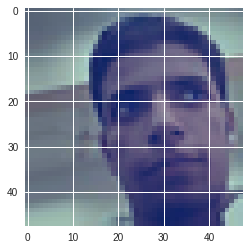

In [0]:
plt.imshow( X[750].reshape(48, 48, 3) )

In [0]:
X.shape, y.shape

((1000, 48, 48, 3), (1000, 4))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
model = ResNet50()

In [0]:
opt = Adam(lr=0.0001)
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

In [0]:
model.fit(
    X_train, 
    y_train,
    validation_data=(X_test,y_test),
    epochs=1000,
    shuffle=True,
    batch_size=128,
    verbose=1
)

Train on 800 samples, validate on 200 samples
Epoch 1/1000
800/800 [==============================] - 3s 4ms/step - loss: 1.8925 - acc: 0.2662 - val_loss: 1.9591 - val_acc: 0.2700
Epoch 2/1000
800/800 [==============================] - 3s 3ms/step - loss: 1.8195 - acc: 0.2988 - val_loss: 1.8169 - val_acc: 0.2950
Epoch 3/1000
800/800 [==============================] - 3s 3ms/step - loss: 1.8341 - acc: 0.2775 - val_loss: 1.9199 - val_acc: 0.2500
Epoch 4/1000
800/800 [==============================] - 3s 3ms/step - loss: 1.8782 - acc: 0.2700 - val_loss: 1.7143 - val_acc: 0.2950
Epoch 5/1000
800/800 [==============================] - 3s 3ms/step - loss: 2.0046 - acc: 0.2450 - val_loss: 1.8967 - val_acc: 0.2650
Epoch 6/1000
800/800 [==============================] - 3s 3ms/step - loss: 1.9798 - acc: 0.2400 - val_loss: 1.9003 - val_acc: 0.2750
Epoch 7/1000
800/800 [==============================] - 3s 3ms/step - loss: 1.8425 - acc: 0.2512 - val_loss: 1.9086 - val_acc: 0.2300
Epoch 8/1000
800

In [0]:
names = ['karim', 'omar', 'amr', 'farouq']

In [0]:
model.evaluate(X_test, y_test)

200/200 [==============================] - 0s 1ms/step


[0.8512250328063965, 0.835]

In [0]:
def testByIndex(data, labels, index=None):
  index = np.random.randint(0, data.shape[0]) if index == None else index
  plt.imshow(data[index].reshape(48, 48, 3))
  pred = model.predict(data[index].reshape(1, 48, 48, 3))
  return (names[np.argmax(pred)], names[np.argmax(labels[index])], pred)

predicted vector:[[9.9409062e-01 1.3239375e-04 5.7765390e-03 3.9374919e-07]]
predicted: karim 
truth: karim


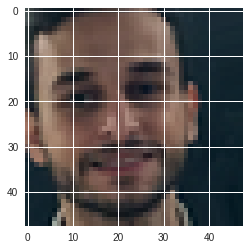

In [0]:
res = testByIndex(X_train, y_train)
print(f"predicted vector:{res[2]}", )
print("predicted:", res[0], "\ntruth:", res[1])

In [0]:
print("train acc: ", np.sum(np.argmax(model.predict(X_train), axis=1) == np.argmax(y_train, axis=1)) / 800)

train acc:  0.96


In [0]:
print("test acc: ", np.sum(np.argmax(model.predict(X_test), axis=1) == np.argmax(y_test, axis=1)) / 200)

test acc:  0.835


In [0]:
model.save("model.mdl")

In [0]:
!ls

dataObject.pkl	model.mdl  sample_data


In [0]:
from keras.models import load_model

In [0]:
model = load_model("model.mdl")

('karim', 'amr')

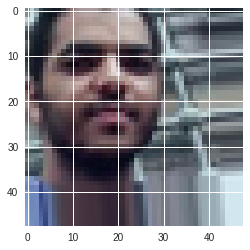

In [111]:
index = np.random.randint(0, 800)
plt.imshow(X_train[index].reshape(48, 48, 3))
names[np.argmax(model.predict(X_train[index].reshape(1, 48, 48, 3)))], names[np.argmax(y_train[index])]

In [0]:
!pip3 install pydrive

    100% |████████████████████████████████| 993kB 20.5MB/s 
  Running setup.py bdist_wheel for pydrive ... - \ done
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

def upload(path, folder_id):
	# Authenticate and create the PyDrive client.
	auth.authenticate_user()
	gauth = GoogleAuth()
	gauth.credentials = GoogleCredentials.get_application_default()
	drive = GoogleDrive(gauth)
	if not os.path.exists(path):
		print("wrong path")
		return
	if os.path.isfile(path):
		uploadFile(drive, path, folder_id)
	else:
		uploadDirectory(drive, path, folder_id)


def uploadDirectory(drive, directoryPath, folder_id):
	# create foder in drive under folder with folder id = folder_id

	dirName = getName(directoryPath)
	print("uploading directory : {name}".format(name=element))
	metadata = {'parents':[{u'id': folder_id}], 'title' : dirName, 'mimeType' : 'application/vnd.google-apps.folder'}
	folder = drive.CreateFile(metadata)
	folder.Upload()
	new_folder_id = folder.attr['metadata']['id']

	for element in os.listdir(directoryPath):
		elementPath = os.path.join(directoryPath, element)
		if os.path.isfile(elementPath):
			uploadFile(drive, elementPath, new_folder_id)
		elif os.path.isdir(elementPath):
			uploadDirectory(drive, elementPath, new_folder_id)
	
	print("uploaded directory  : {name}".format(name=element))

def uploadFile(drive, filePath, folder_id):
	if os.stat(filePath).st_size == 0:
		return
	print("uploading file : {name}".format(name=getName(filePath)))
	file = drive.CreateFile({'parents':[{u'id': folder_id}], 'title':getName(filePath)})
	file.SetContentFile(filePath)
	file.Upload()
	print("uploaded file  : {name}".format(name=getName(filePath)))


def getName(path):
	return path.split('/')[-1] if path.split('/')[-1] != '' else path.split('/')[-2]

In [0]:
folder_id = '1AHB09g_MMM73vmCGEgrg0MVzzKih0Uh_'
upload("model.mdl", folder_id)

uploading file : model.mdl
uploaded file  : model.mdl


In [109]:
!ls

adc.json  dataObject.pkl  model.mdl  sample_data


In [0]:
def testAndPlot(data, labels):
  start = np.random.randint(0, data.shape[0]-21)
  end = start + 20
  images = data[start:end,:,:]
  preds = [ names[prediction] for prediction in np.argmax(model.predict(images.reshape(-1, 48, 48, 3)), axis=1) ]
  plt.figure(figsize=(4, 5))

  correctPredections = 0
  wrongPredictions = 0

  images = zip(images, preds)
  for i, (img, pred) in enumerate(images):
      plt.subplot(4, 5, i + 1)
      plt.imshow(img)

      if names[np.argmax(labels[start+i])] == pred:
        correctPredections += 1
        color = 'g'
      else:
        wrongPredictions += 1
        color = 'r'
      plt.title(pred, color=color)
  plt.show()
  print(f"Correctly Classified: {correctPredections}")
  print(f"MisClassified: {wrongPredictions}")

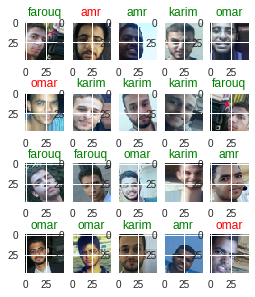

Correctly Classified: 17
MisClassified: 3


In [139]:
testAndPlot(X_test, y_test)